In [2]:
from typing import Tuple

import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn.utils
from sklearn.model_selection import train_test_split

import matplotlib.colors as colors
import matplotlib.pyplot as plt
DEFAULT_BATCH_SIZE = 2
DEFAULT_EARLY_STOPPING_PAT = 3


## Some code for the models adjusted for multiclass classification

In [21]:
class MLPModule(nn.Module):
    """Create a new multi-layer perceptron instance with ReLU activations and no non-linearity in
    the output layer.

    Parameters
    ----------
    hidden_sizes: list
        The sizes of the hidden layers.
    input_size: int
        The input size.
    dropout_rate: float
        The dropout rate applied after each layer (except the output layer)
    output_size: int
        The output size.
    do_batch_norm: bool
        Whether to apply batch normalization after each layer.
    """

    def __init__(self, hidden_sizes: list, input_size: int, dropout_rate: float,
                 output_size: int = 1, do_batch_norm: bool = False):
        super(MLPModule, self).__init__()
        layers = []

        if len(hidden_sizes) > 0:
            layers.append(nn.Linear(input_size, hidden_sizes[0]))
            if do_batch_norm:
                layers.append(nn.BatchNorm1d(num_features=hidden_sizes[0]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            if do_batch_norm:
                layers.append(nn.BatchNorm1d(num_features=hidden_sizes[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

        layers.append(nn.Linear(hidden_sizes[-1], output_size))

        self.mlp = nn.Sequential(*layers)

    def forward(self, _input: torch.Tensor) -> torch.Tensor:
        """Perform a forward pass of the MLP.

        Parameters
        ----------
        _input: torch.Tensor
            The input of the model.

        Returns
        -------
        type: torch.Tensor
            The output of the model.
        """
        return self.mlp(_input)


class SimpleDataset(Dataset):
    """Create a new (simple) PyTorch Dataset instance.

    Parameters
    ----------
    X: torch.Tensor
        Predictors
    y: torch.Tensor
        Target
    """

    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X
        self.y = y

    def __len__(self):
        """Return the number of items in the dataset.

        Returns
        -------
        type: int
            The number of items in the dataset.
        """
        return self.X.shape[0]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """Return X and y at index idx.

        Parameters
        ----------
        idx: int
            Index.

        Returns
        -------
        type: Tuple[torch.Tensor, torch.Tensor]
            X and y at index idx
        """
        return self.X[idx], self.y[idx]


class MLP:
    """Handles training of an MLPModule.

    Parameters
    ----------
    hidden_sizes: list
        The sizes of the hidden layers.
    input_size: int
        The input size.
    output_size: int
        The output size.
    dropout_rate: float
        The dropout rate applied after each layer (except the output layer)
    batch_norm: bool
        Whether to apply batch normalization after each layer.
    """

    def __init__(self, hidden_sizes: list, input_size: int, dropout_rate: float,
                 class_weight: bool = True, output_size: int = 1, batch_norm: bool = False):
        self.model = MLPModule(hidden_sizes, input_size, dropout_rate, output_size, batch_norm)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.class_weight = class_weight

    def _initialize_dataloader(self, X_train: np.ndarray, y_train: np.ndarray, batch_size: int):
        """Initialize the dataloader of the train data.

        Parameters
        ----------
        X_train: np.ndarray
            The training data.
        y_train: np.ndarray
            The labels corresponding to the training data.
        batch_size:
            The batch size.
        """
        train_set = SimpleDataset(torch.from_numpy(X_train),
                                  torch.from_numpy(y_train))
        self.train_loader = DataLoader(train_set, batch_size, shuffle=True)

    def validate(self, X_val: np.ndarray, y_val: np.ndarray) -> torch.Tensor:
        """Calculate the validation loss.

        Parameters
        ----------
        X_val: np.ndarray
            The validation data.
        y_val: np.ndarray
            The labels corresponding to the validation data.

        Returns
        -------
        type: torch.Tensor
            The validation loss.
        """
        self.model.eval()
        y_pred = self.model(torch.tensor(X_val).float())
        loss_fn = torch.nn.CrossEntropyLoss()
        val_loss = loss_fn(y_pred, torch.tensor(y_val).long())
        return val_loss

    def train(self, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray,
              batch_size, n_epochs,
              early_stopping: bool =False,
              early_stopping_patience: int = DEFAULT_EARLY_STOPPING_PAT):
        """Train the MLP.

        Parameters
        ----------
        X_train: np.ndarray
            The training data.
        y_train: np.ndarray
            The labels corresponding to the training data.
        X_val: np.ndarray
            The validation data.
        y_val: np.ndarray
            The labels corresponding to the validation data.
        batch_size: int
            The batch size, default 256
        n_epochs: int
            The number of training epochs, default 30
        early_stopping: bool
            Whether to perform early stopping, default True
        early_stopping_patience: int
            The early stopping patience, default 2.
        """

        self._initialize_dataloader(X_train, y_train, batch_size)
        prev_val_loss = float('inf')
        n_no_improvement = 0
        for epoch in range(n_epochs):

            self.model.train()
            for batch_X, batch_y in self.train_loader:
                y_pred = self.model(batch_X.float())
                loss_fn = torch.nn.CrossEntropyLoss()
                loss = loss_fn(y_pred, batch_y.long())
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            if early_stopping:
                val_loss = self.validate(X_val, y_val)
                if val_loss > prev_val_loss:
                    n_no_improvement += 1
                else:
                    n_no_improvement = 0
                    prev_val_loss = val_loss
            if n_no_improvement >= early_stopping_patience:
                break

class NNEnsemble:
    """Wrapper class for an ensemble of neural networks.

    Parameters
    ----------
    n_models: int
        The number of ensemble members.
    model_params: dict
        The model parameters, see class MLP.
    """

    def __init__(self, n_models: int, model_params: dict):
        self.n_models = n_models
        self.model_params = model_params
        self.models = dict()

    def train(self, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray,
              training_params: dict, mlp_class=MLP):
        """Train all MLPs on the training data.

        Parameters
        ----------
        X_train: np.ndarray
            The training data
        y_train: np.ndarray
            The labels corresponding to the training data.
        X_val: np.ndarray
            The validation data
        y_val: np.ndarray
            The labels corresponding to the validation data.
        training_params: dict
            The parameters used for training, see class MLP.
        """
        for i in range(self.n_models):
            mlp = mlp_class(**self.model_params)
            mlp.train(X_train, y_train, X_val, y_val,
                      **training_params)
            self.models[i] = mlp.model

    def predict_proba(self, X_test: np.ndarray) -> np.ndarray:
        """Predict the probabilities p(y|X) by averaging the predictions of ensemble members.

        Parameters
        ----------
        X_test: np.ndarray
            The test data.

        Returns
        -------
        type:np.ndarray
            The predicted probabilities.
        """
        predictions = []
        X_test_tensor = torch.tensor(X_test).float()
        for i in range(self.n_models):
            self.models[i].eval()
            predictions.append(torch.softmax(
                self.models[i](X_test_tensor), dim=1).detach().squeeze().numpy())
        return np.array(predictions).mean(axis=0)

In [27]:
from math import sqrt

class AnchoredMLP(MLP):
    """
    Implement a member of an anchored ensembles as described in [1]. The main difference compared to regular ensembles
    of Deep Neural Networks is that they use a special kind of weight decay regularization, which makes the whole
    process Bayesian.

    [1] https://arxiv.org/pdf/1810.05546.pdf
    """

    def __init__(
        self,
        hidden_sizes: list,
        input_size: int,
        dropout_rate: float,
        class_weight: bool = True,
        output_size: int = 1,
        batch_norm: bool = False
    ):

        super().__init__(
            hidden_sizes,
            input_size,
            dropout_rate=0,
            class_weight=class_weight,
            output_size=output_size,
            batch_norm=False,
        )

        self.anchors = self.sample_anchors_and_resample_weights()

    def sample_anchors_and_resample_weights(self):
        """
        Sample parameter anchors from the same prior normal distribution with zero mean and sqrt(prior_scale) variance.

        Returns
        -------
        anchors: Dict[str, torch.FloatTensor]
            Dictionary mapping from parameter name to the parameter's anchor.
        """
        anchors = {}

        for name, param in self.model.mlp.named_parameters():
            # Usually torch weight matrices are initialized by sampling from U[-sqrt(1/k), sqrt(1/k)]
            # Because anchored ensembling requires initializing them from a normal distribution, use kaiming init
            # instead which samples from N(0, sqrt(2/k))
            k = (
                param.shape[1] if len(param.shape) == 2 else param.shape[0]
            )  # Distinguish between weights and biases
            prior_scale = sqrt(2 / k)
            std = sqrt(prior_scale)
            anchors[name] = torch.normal(0, std, size=param.size())
            param.data.normal_(0, std)  # Re-sample weights from normal distribution

        return anchors

    def anchor_loss(self, labels: torch.Tensor):
        loss = 0
        N = labels.shape[0]

        for name, param in self.model.mlp.named_parameters():
            anchor = self.anchors[name]

            # Create diagonal Lambda matrix
            k = param.shape[1] if len(param.shape) == 2 else param.shape[0]
            prior_scale = sqrt(2 / k)
            Lambda = torch.diag(
                torch.ones(size=(param.shape[0],)) * sqrt(1 / 2 * prior_scale)
            )

            loss += torch.norm(Lambda @ (param - anchor)) / N

        return loss

    def get_loss_fn(self, mean_y: torch.Tensor):
        """
        Return a modified loss function which includes the anchored ensembles loss.
        """
        bce_loss = super().get_loss_fn(mean_y)

        return lambda pred, labels: bce_loss(pred, labels) + self.anchor_loss(labels)


class AnchoredNNEnsemble(NNEnsemble):
    """
    Implement anchored ensembles as described in [1]. The main difference compared to regular ensembles of Deep Neural
    Networks is that they use a special kind of weight decay regularization, which makes the whole process Bayesian.

    [1] https://arxiv.org/pdf/1810.05546.pdf
    """

    def __init__(self, n_models: int, model_params: dict):
        super().__init__(n_models, model_params)

    def train(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val: np.ndarray,
        y_val: np.ndarray,
        training_params: dict,
        mlp_class: type = MLP,
    ):
        """Train all MLPs on the training data.

        Parameters
        ----------
        X_train: np.ndarray
            The training data
        y_train: np.ndarray
            The labels corresponding to the training data.
        X_val: np.ndarray
            The validation data
        y_val: np.ndarray
            The labels corresponding to the validation data.
        training_params: dict
            The parameters used for training, see class MLP.
        """
        super().train(
            X_train, y_train, X_val, y_val, training_params, mlp_class=AnchoredMLP
        )


## Functions that are used later to generate data and plot

In [8]:
def generate_cluster(mean, diag_cov, size, label):
    c = np.random.multivariate_normal(mean=mean, cov=[[diag_cov, 0],[0,diag_cov]], size=size)
    c = np.expand_dims(c, 2)
    y = np.ones(shape=(c.shape[0],1,1))*label
    c = np.concatenate([c, y], axis=1)
    return c

def plot_single_grid(X, y, xx, yy, grid, alpha=0.1, s=50, title='', uncertainty=True, 
                     colorbar=True, vmin=None, vmax=None):
    if colorbar:
        plt.figure(figsize=(6,5))
    else:
        plt.figure(figsize=(5,5))
    if uncertainty:
        cmap = plt.cm.Purples
    else: 
        cmap = plt.cm.RdBu
    c = plt.contourf(xx, yy, grid.reshape(xx.shape), cmap=cmap,
                    levels=20, vmin=vmin, vmax=vmax)
    if colorbar:
        plt.colorbar(c)
    plt.scatter(X[:, 0], X[:, 1], c=y,cmap='Set1', 
                edgecolors='k', alpha=alpha, s=s)
    plt.axis('off')
    plt.title(title)
    
def entropy(pk, axis):
    return -np.sum(pk * np.log2(pk+1e-8), axis=axis)

## Ugly code to generate data

In [9]:
positive_size, negative_size = 50, 50 

one_mean = np.array([ 0.5, -0.5])
two_mean = np.array([0,-1.5])
three_mean = np.array([-1.3,-1])
four_mean = np.array([-1.5,0])
five_mean = np.array([-0.1,0.5])
six_mean = np.array([ -2.5, 0.5])
seven_mean = np.array([ 1.5, 0])
eight_mean = np.array([2, 1.1])
nine_mean = np.array([2, -1.5])
one_cluster = generate_cluster(one_mean, np.random.uniform(0.02,0.1), positive_size, label=0)
two_cluster = generate_cluster(two_mean, np.random.uniform(0.02,0.1), negative_size, label=1)
three_cluster = generate_cluster(three_mean, np.random.uniform(0.02,0.1), negative_size, label=2)
four_cluster = generate_cluster(four_mean, np.random.uniform(0.02,0.1), negative_size, label=3)
five_cluster = generate_cluster(five_mean, np.random.uniform(0.02,0.1), negative_size, label=4)
six_cluster = generate_cluster(six_mean, np.random.uniform(0.02,0.1), negative_size, label=5)
seven_cluster = generate_cluster(seven_mean, np.random.uniform(0.02,0.1), negative_size, label=6)
eight_cluster = generate_cluster(eight_mean,np.random.uniform(0.02,0.1), negative_size, label=7)
nine_cluster = generate_cluster(nine_mean,np.random.uniform(0.02,0.1), negative_size, label=8)
concatenated = np.concatenate([one_cluster, two_cluster, three_cluster, four_cluster, 
                               five_cluster, six_cluster, seven_cluster, eight_cluster, nine_cluster], axis=0)

columns = ['f1', 'f2']
label = 'label'
df_model = pd.DataFrame(concatenated[:,:,0], columns=columns+[label])
df_model = sklearn.utils.shuffle(df_model, random_state=1)

X_train = df_model[columns].values
y_train = df_model[label].values

step_size = .1 
x_min, x_max = -3.5,3
y_min, y_max = -2.3,2


xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size),
                     np.arange(y_min, y_max, step_size))

X_grid = np.c_[xx.ravel(), yy.ravel()]

## Plot data

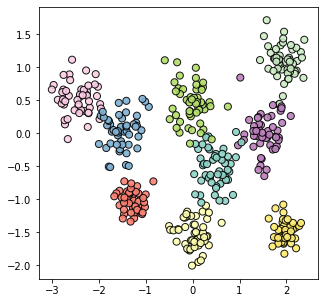

In [10]:
sns.set_palette("Set1", 10)
plt.figure(figsize=(5,5))
plt.scatter(X_train[:, 0], X_train[:, 1],  c=y_train, cmap='Set3',
                edgecolors='k', alpha=0.9, s=50)

## Initialize and train model

In [11]:
model_params = {'hidden_sizes': [5,5],
                'dropout_rate': 0.0,
                'input_size': 2,
                 'output_size':9,
                'batch_norm': False}

training_params = {'batch_size':8,'n_epochs':100, 'early_stopping':True}

In [12]:
model = MLP(**model_params)
model.train(X_train, y_train, X_train, y_train, **training_params)

# Single model predictions
model.model.eval()

predictions = torch.softmax(model.model(torch.tensor(X_grid).float()), dim=1).detach().numpy()
grid_uncertainties = entropy(predictions, axis=1)

In [13]:
nn_ensemble = NNEnsemble(n_models=10, model_params=model_params)
nn_ensemble.train(X_train, y_train, X_train, y_train, training_params)

# Predictions of ensemble
grid_predictions_ensemble = nn_ensemble.predict_proba(X_grid)
grid_uncertainties_ensemble = entropy(grid_predictions_ensemble, axis=1)

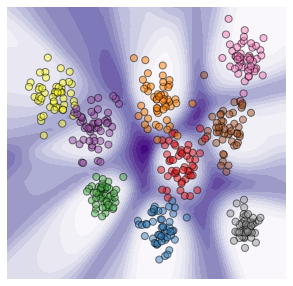

In [14]:
plot_single_grid(X_train, y_train, xx, yy, grid_uncertainties_ensemble, s=50, alpha=0.5,title='', uncertainty=True, 
                     colorbar=False)
plt.savefig('multiclass_ensemble.png', dpi=300)

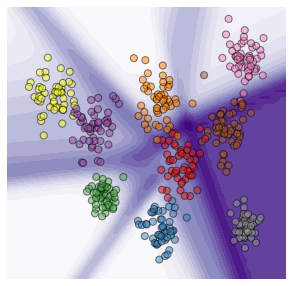

In [15]:
plot_single_grid(X_train, y_train, xx, yy, grid_uncertainties, s=50, title='', alpha=0.5, uncertainty=True, 
                     colorbar=False)
plt.savefig('multiclass_single.png', dpi=300)

In [28]:
# Train anchored ensemble
nn_anchored_ensemble = AnchoredNNEnsemble(n_models=10, model_params=model_params)
nn_anchored_ensemble.train(X_train, y_train, X_train, y_train, training_params)

# Predictions of ensemble
grid_predictions_anchored_ensemble = nn_anchored_ensemble.predict_proba(X_grid)
grid_uncertainties_anchored_ensemble = entropy(grid_predictions_anchored_ensemble, axis=1)

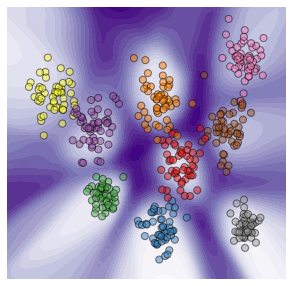

In [29]:
plot_single_grid(X_train, y_train, xx, yy, grid_uncertainties_anchored_ensemble, s=50, alpha=0.5,title='', uncertainty=True, 
                     colorbar=False)
plt.savefig('multiclass_anchored_ensemble.png', dpi=300)